<center> Advanced Integration and Annotation of scRNA-seq Data Using scVI: Hyperparameter Tuning, Label Transfer, and Custom Reference Creation - Part 2

# Label Transfer and Hyperparameter Tuning

Following successful integration and label transfer, the scVI model requires fine-tuning to optimize its performance. The `ModelTuner` function from the `scvi` module will be employed to adjust the neural network hyperparameters, ensuring accurate label transfer and robust integration.

This step focuses on:

- Improving classification accuracy of transferred labels.
- Reducing batch effect noise while preserving biological signal.
- Enhancing model generalizability for downstream analyses.

Hyperparameter tuning will be performed using the `tune_hyperparameters()` method, enabling automatic selection of the best parameters based on a predefined metric (e.g., log-likelihood or classification accuracy). Once tuned, the model will be retrained on the full dataset. [GitHub reference](https://github.com/mousepixels/sanbomics_scripts/blob/main/sc2024/annotation_integration.ipynb)

Next, we proceed with the implementation.


# Integration

In this step, we will perform batch integration. It is essential to fine-tune the network for optimal predictions. The goal is to predict the latent space (hidden layer) of the network, and then perform K-Nearest Neighbors (KNN) and Leiden clustering on this layer.


<div class="alert alert-block alert-danger">
<b>bash file:</b> Breast_Cancer_scVI_LabelTransfer.py
</div>

```python

# This code uses the scvitools/1.2.0.gpu module on the Biowulf cluster with 3 GPUs (A100).
# On average, one training epoch takes 30 seconds when using this module.
# However, it does not perform well with the version of scVI installed manually.
# With the manually installed scVI, one training epoch takes only 0.5 seconds.

# The tuning process is recommended for 100 samples (`num_samples`), 
# which involves training 100 different models, each with varying parameters.
# If tuning is done at maximum capacity (100 models, 100 epochs each), 
# the total time required would be:
# (0.5 seconds/epoch * 100 epochs/model * 100 models) / 60 = 83 hours.

# This duration is too long to be practical. 
# It is advisable to reduce the number of samples to 20, which would result in:
# (0.5 seconds/epoch * 100 epochs/model * 20 models) / 60 = 16 hours.
# This is a more reasonable runtime for tuning.

# For more details on the tuning process, refer to the official scVI documentation:
# https://docs.scvi-tools.org/en/1.2.0/tutorials/notebooks/tuning/autotune_scvi.html

import ray
import scanpy as sc
import scvi
import seaborn as sns
import torch
from ray import tune
from scvi import autotune
import os

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"
andata_combined = sc.read_h5ad(os.path.join(pathout, "adata_concat_BreastCancer_harmony_scVI_scANVI_unintigrated.h5ad"))
andata_bc = andata_combined[andata_combined.obs['sample']=='ST'].copy()

model_cls = scvi.model.SCVI
model_cls.setup_anndata(andata_bc, categorical_covariate_keys = ['batch'])


search_space = {
    "model_params": {"n_hidden": tune.choice([92, 128]),
        "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
        "n_layers": tune.choice([1, 2, 3]),
        #"lr": tune.loguniform(1e-4, 1e-2),
        "gene_likelihood": tune.choice(["nb", "zinb"])},
    "train_params": {"max_epochs": 100},
}

ray.init(log_to_driver=False)
results = autotune.run_autotune(
    model_cls,
    data=andata_bc,
    mode="min",
    metrics="validation_loss",
    search_space=search_space,
    num_samples=20,
    resources={"gpu": 3})

df = results.result_grid.get_dataframe(filter_metric="accuracy", filter_mode="max")
df.to_csv(os.path.join(pathout,"tune_hyper_scVI.csv"))
```

In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)


In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
#import celltypist
#from celltypist import models
from scvi.autotune import ModelTuner
from ray import tune
import ray

torch.set_float32_matmul_precision("high")
print("scvi-tools version:", scvi.__version__)

scvi-tools version: 1.1.6.post2


In [3]:
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_4"
andata_combined = sc.read_h5ad(os.path.join(pathout, "adata_concat_BreastCancer_harmony_scVI_scANVI_unintigrated.h5ad"))
andata_bc = andata_combined[andata_combined.obs['sample']=='ST'].copy()

Data frame summaries the model hyperparameters search.

In [5]:
df = pd.read_csv(os.path.join(pathout,"tune_hyper.csv"))

In [12]:
df.sort_values(by='validation_loss').head(1)

,Unnamed: 0,validation_loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,...,hostname,node_ip,time_since_restore,iterations_since_restore,config/model_params/n_hidden,config/model_params/n_latent,config/model_params/n_layers,config/model_params/gene_likelihood,config/train_params/max_epochs,logdir
6,6,151.369537,1732569046,NaN,False,10,a2bfad78,2024-11-25_16-10-46,28.163898,283.204799,...,cn0798,10.2.23.30,283.204799,10,92,50,1,nb,10,a2bfad78


In [13]:
model = scvi.model.SCVI
model.setup_anndata(andata_bc, categorical_covariate_keys = ['batch'])

In [15]:
model = scvi.model.SCVI(andata_bc, n_hidden = 92, n_latent = 50, n_layers = 1, gene_likelihood = 'nb')

In [16]:
model.train(max_epochs = 200, early_stopping = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 200/200: 100%|████████| 200/200 [1:05:38<00:00, 19.78s/it, v_num=1, train_loss_step=161, train_loss_epoch=168]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████████| 200/200 [1:05:38<00:00, 19.69s/it, v_num=1, train_loss_step=161, train_loss_epoch=168]


In [17]:
model.save('the_model')

In [19]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

In [31]:
y = model.history['reconstruction_loss_validation'].values.min()

In [24]:
model.history['reconstruction_loss_validation']

,reconstruction_loss_validation
epoch,
0,154.643524
1,151.685059
2,150.432053
3,149.861618
4,149.349365
...,...
195,159.545761
196,159.546814
197,159.694626


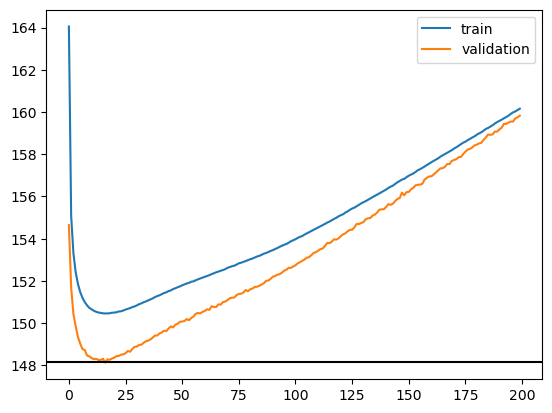

In [32]:
plt.plot(model.history['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [ ]:
andata_bc.obsm['X_scVI'] = model.get_latent_representation()